In [58]:
from torch import cuda

cuda.is_available()

True

##1. import & Data load

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [59]:
pip install catboost

In [60]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import norm
from scipy import stats
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm
import bisect
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split,cross_val_score, KFold

from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import VotingRegressor

import warnings
warnings.filterwarnings(action='ignore')

In [61]:
train = pd.read_csv('/content/drive/MyDrive/프로젝트/HD현대 AI Challenge /data/train.csv').drop(columns=['SAMPLE_ID','ID'])
test = pd.read_csv('/content/drive/MyDrive/프로젝트/HD현대 AI Challenge /data/test.csv').drop(columns=['SAMPLE_ID','ID'])

train, test SAMPLE_ID, ID 삭제

##2. EDA & Preprocessing

In [62]:
# 데이터 탐색
display(train.head())
display(train.info())
display(train.describe())
# 결측치 확인
display(train.isnull().sum())

,ARI_CO,ARI_PO,SHIP_TYPE_CATEGORY,DIST,ATA,BREADTH,BUILT,DEADWEIGHT,DEPTH,DRAUGHT,...,V_WIND,AIR_TEMPERATURE,BN,ATA_LT,DUBAI,BRENT,WTI,BDI_ADJ,PORT_SIZE,CI_HOUR
0,CN,EKP8,Bulk,30.736578,2020-10-15 4:03,30.0,28,73100,20.0,10.0,...,3.77,15.9,2.730798,12,42.01,43.16,40.96,1407.668330,0.001660,3.048333
1,CN,EUC8,Container,63.220425,2019-09-17 2:55,30.0,15,37900,20.0,10.0,...,-6.72,24.5,4.289058,10,67.53,64.55,59.34,2089.046774,0.001614,17.138611
2,CN,NGG6,Container,90.427421,2019-02-23 6:43,50.0,7,115000,20.0,10.0,...,0.00,9.4,0.000000,14,65.30,66.39,56.94,603.193047,0.001743,98.827500
3,JP,TMR7,Cargo,0.000000,2020-09-18 22:06,10.0,33,1490,10.0,0.0,...,-7.31,22.1,4.693735,7,43.02,43.15,41.11,1169.853455,0.000069,0.000000
4,RU,NNC2,Container,8.813725,2022-08-13 12:57,30.0,10,27600,10.0,10.0,...,2.31,22.8,2.345875,14,90.45,93.65,88.11,1107.944894,0.000197,96.030556


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 367441 entries, 0 to 367440
Data columns (total 25 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   ARI_CO              367441 non-null  object 
 1   ARI_PO              367441 non-null  object 
 2   SHIP_TYPE_CATEGORY  367441 non-null  object 
 3   DIST                367441 non-null  float64
 4   ATA                 367441 non-null  object 
 5   BREADTH             367440 non-null  float64
 6   BUILT               367441 non-null  int64  
 7   DEADWEIGHT          367441 non-null  int64  
 8   DEPTH               367440 non-null  float64
 9   DRAUGHT             367440 non-null  float64
 10  GT                  367441 non-null  int64  
 11  LENGTH              367440 non-null  float64
 12  SHIPMANAGER         367441 non-null  object 
 13  FLAG                367441 non-null  object 
 14  U_WIND              213955 non-null  float64
 15  V_WIND              213955 non-nul

None

,DIST,BREADTH,BUILT,DEADWEIGHT,DEPTH,DRAUGHT,GT,LENGTH,U_WIND,V_WIND,AIR_TEMPERATURE,BN,ATA_LT,DUBAI,BRENT,WTI,BDI_ADJ,PORT_SIZE,CI_HOUR
count,367441.000000,367440.000000,367441.000000,367441.000000,367440.000000,367440.000000,367441.000000,367440.000000,213955.000000,213955.000000,213076.000000,213955.000000,367441.000000,367441.000000,367441.00000,367441.000000,367441.000000,367441.000000,367441.000000
mean,19.315929,30.550239,14.746082,63588.867056,16.476540,11.086708,41346.606612,205.114468,-0.297587,-0.262955,18.867344,2.706476,11.837903,65.533814,67.55712,63.209494,1348.251333,0.000877,61.877118
std,30.903272,10.957441,7.040392,63558.705308,6.047015,4.600020,39311.578997,75.867383,3.365912,3.735113,9.727090,1.387629,6.645665,20.916641,20.98516,20.630433,738.961048,0.000838,170.575224
min,0.000000,10.000000,0.000000,100.000000,0.000000,0.000000,150.000000,20.000000,-25.330000,-21.450000,-32.200000,0.000000,0.000000,13.520000,19.33000,-37.630000,286.802297,0.000005,0.000000
25%,0.000000,20.000000,10.000000,14400.000000,10.000000,10.000000,10000.000000,150.000000,-2.150000,-2.280000,12.200000,1.804286,7.000000,50.020000,51.46000,48.360000,836.349201,0.000142,0.000000
50%,6.929929,30.000000,13.000000,47400.000000,20.000000,10.000000,30700.000000,190.000000,-0.130000,0.000000,21.600000,2.618063,12.000000,62.930000,64.62000,59.140000,1187.573732,0.000552,7.949444
75%,25.693063,40.000000,18.000000,81400.000000,20.000000,10.000000,52100.000000,260.000000,1.540000,2.000000,26.600000,3.556008,17.000000,76.880000,79.30000,74.250000,1660.987616,0.001614,49.153333
max,199.980651,60.000000,80.000000,404000.000000,30.000000,20.000000,237000.000000,400.000000,17.910000,29.690000,47.600000,11.179660,23.000000,127.860000,127.98000,123.700000,4795.865609,0.002615,2159.130556


ARI_CO                     0
ARI_PO                     0
SHIP_TYPE_CATEGORY         0
DIST                       0
ATA                        0
BREADTH                    1
BUILT                      0
DEADWEIGHT                 0
DEPTH                      1
DRAUGHT                    1
GT                         0
LENGTH                     1
SHIPMANAGER                0
FLAG                       0
U_WIND                153486
V_WIND                153486
AIR_TEMPERATURE       154365
BN                    153486
ATA_LT                     0
DUBAI                      0
BRENT                      0
WTI                        0
BDI_ADJ                    0
PORT_SIZE                  0
CI_HOUR                    0
dtype: int64

1. 범주형 변수: ARI_CO, ARI_PO, SHIP_TYPE_CATEGORY ,SHIPMANAGER ,FLAG
2. 수치형 변수: 나머지
3. 풍향 u,v벡터, 기온, 보퍼트 풍력 계급 변수에 결측치 존재

In [63]:
# DIST가 0이면 CI_HOUR도 0이어야함 - 개념적으로
DIST_0 = train[train['DIST'] == 0]
CI_HOUR_NOT_0_idx = DIST_0.index[DIST_0['CI_HOUR'] != 0].tolist()
train.loc[CI_HOUR_NOT_0_idx, ['CI_HOUR']] = 0
train

,ARI_CO,ARI_PO,SHIP_TYPE_CATEGORY,DIST,ATA,BREADTH,BUILT,DEADWEIGHT,DEPTH,DRAUGHT,...,V_WIND,AIR_TEMPERATURE,BN,ATA_LT,DUBAI,BRENT,WTI,BDI_ADJ,PORT_SIZE,CI_HOUR
0,CN,EKP8,Bulk,30.736578,2020-10-15 4:03,30.0,28,73100,20.0,10.0,...,3.77,15.9,2.730798,12,42.01,43.16,40.96,1407.668330,0.001660,3.048333
1,CN,EUC8,Container,63.220425,2019-09-17 2:55,30.0,15,37900,20.0,10.0,...,-6.72,24.5,4.289058,10,67.53,64.55,59.34,2089.046774,0.001614,17.138611
2,CN,NGG6,Container,90.427421,2019-02-23 6:43,50.0,7,115000,20.0,10.0,...,0.00,9.4,0.000000,14,65.30,66.39,56.94,603.193047,0.001743,98.827500
3,JP,TMR7,Cargo,0.000000,2020-09-18 22:06,10.0,33,1490,10.0,0.0,...,-7.31,22.1,4.693735,7,43.02,43.15,41.11,1169.853455,0.000069,0.000000
4,RU,NNC2,Container,8.813725,2022-08-13 12:57,30.0,10,27600,10.0,10.0,...,2.31,22.8,2.345875,14,90.45,93.65,88.11,1107.944894,0.000197,96.030556
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
367436,CN,YRT6,Bulk,59.018184,2017-11-11 22:23,40.0,13,93200,20.0,10.0,...,NaN,NaN,NaN,6,61.25,62.21,55.70,1333.609109,0.000360,65.850000
367437,JP,QYY1,Tanker,0.000000,2022-04-29 2:58,10.0,9,1280,0.0,0.0,...,0.87,17.1,1.028558,11,105.37,109.34,104.69,1955.103846,0.000552,0.000000
367438,SG,GIW5,Container,1.768630,2022-07-14 7:58,30.0,6,25000,20.0,10.0,...,3.36,31.7,2.557156,15,97.73,99.10,95.78,1601.291086,0.002615,0.997500
367439,JP,TMR7,Cargo,0.000000,2020-12-22 10:07,10.0,8,2400,10.0,0.0,...,-2.44,10.8,3.055715,19,49.75,50.08,47.02,1191.353331,0.000069,0.000000


In [64]:
# CI_HOUR describe
train['CI_HOUR'].describe()

count    367441.000000
mean         61.869789
std         170.567685
min           0.000000
25%           0.000000
50%           7.947778
75%          49.147500
max        2159.130556
Name: CI_HOUR, dtype: float64

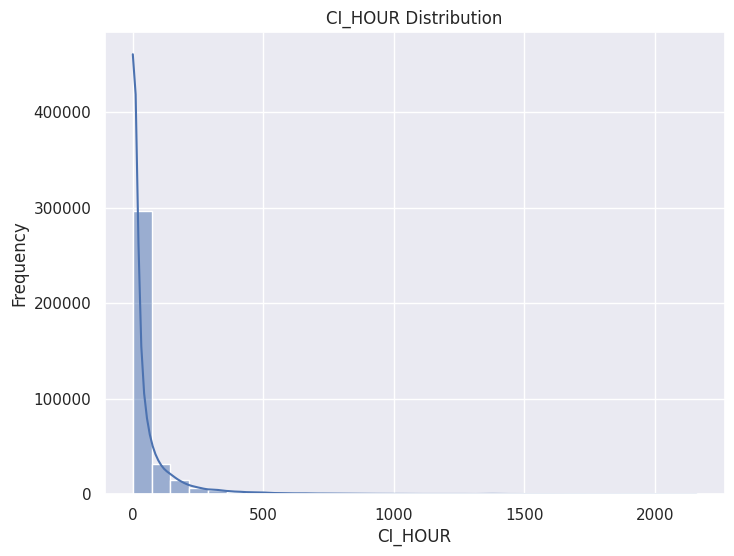

In [65]:
# CI_HOUR의 분포 확인
plt.figure(figsize=(8, 6))
sns.histplot(train['CI_HOUR'], bins=30, kde=True)
plt.title('CI_HOUR Distribution')
plt.xlabel('CI_HOUR')
plt.ylabel('Frequency')
plt.show()

In [66]:
#skewness and kurtosis
print("Skewness: %f" % train['CI_HOUR'].skew())
print("Kurtosis: %f" % train['CI_HOUR'].kurt())

Skewness: 6.167580
Kurtosis: 48.353704


1. 종속변수 값 50이하에 75% 존재
2. 양의 왜도를 가지고 첨도가 매우 높다

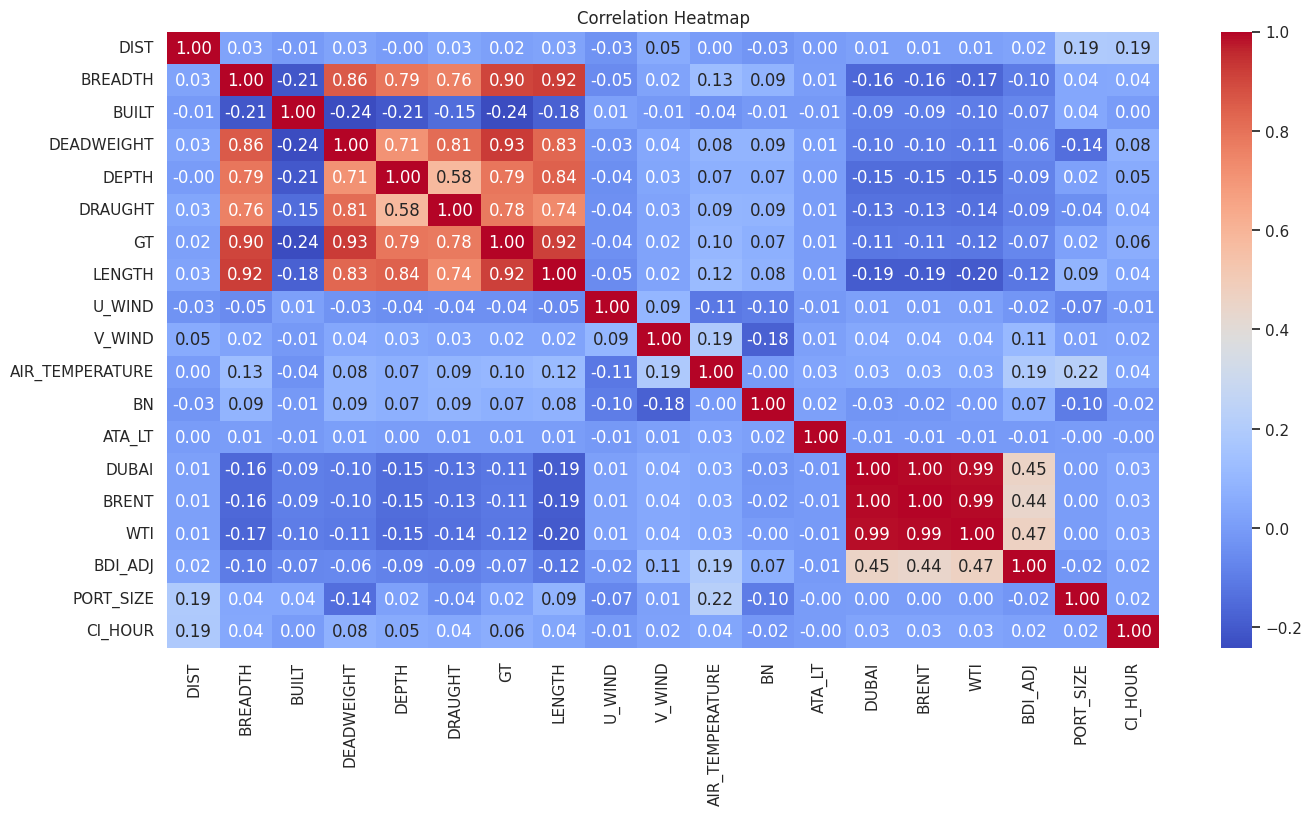

In [67]:
# 시각화를 통한 데이터 탐색
plt.figure(figsize=(16, 8))
sns.heatmap(train.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap')
plt.show()

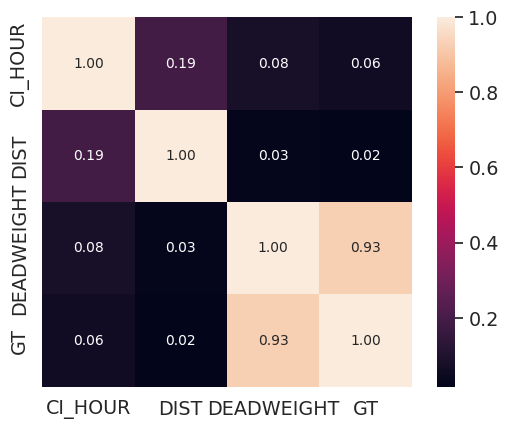

In [68]:
#CI_HOUR correlation matrix
k = 4 #number of variables for heatmap
cols = train.corr().nlargest(k, 'CI_HOUR')['CI_HOUR'].index
cm = np.corrcoef(train[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

1. DIST 변수가 제일 상관관계 높았지만 유의미한 수준이 아님
2. 기름 값 변수들과 선박의 크기및 용적량 변수들 끼리의 상관계수 높게 측정

* breadth, deadweight, depth, draught, gt, length - [폭, 재화중량톤수, 깊이, 흘수높이, 용적톤수, 길이]
* dubai, brent, wti - [두바이유 값, 브렌트유 값, WTI값]
* deadweight, gt는 비슷한 수치라 상관없지만 나머지 변수들은 다중공선성 고려하여 처리 필요
* 기름 값들은 선박의 연료 값이라 관계 높아도 상관없을것으로 추정

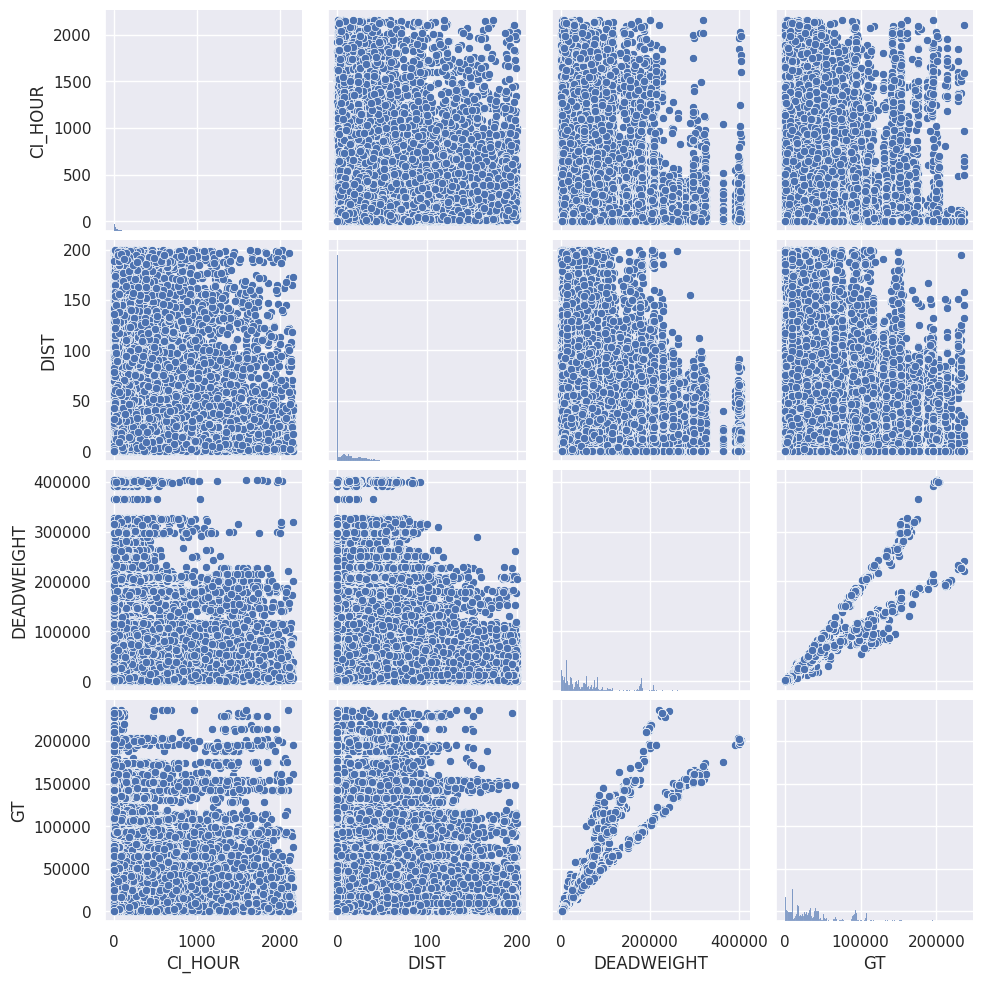

In [69]:
#scatterplot
sns.set()
cols = ['CI_HOUR', 'DIST','DEADWEIGHT', 'GT']
sns.pairplot(train[cols], size = 2.5)
plt.show();

In [70]:
# BUILT, ATA_LT 컬럼 제거
train.drop(columns=['BUILT', 'ATA_LT'], inplace=True)
test.drop(columns=['BUILT', 'ATA_LT'], inplace=True)

train.head()

,ARI_CO,ARI_PO,SHIP_TYPE_CATEGORY,DIST,ATA,BREADTH,DEADWEIGHT,DEPTH,DRAUGHT,GT,...,U_WIND,V_WIND,AIR_TEMPERATURE,BN,DUBAI,BRENT,WTI,BDI_ADJ,PORT_SIZE,CI_HOUR
0,CN,EKP8,Bulk,30.736578,2020-10-15 4:03,30.0,73100,20.0,10.0,38600,...,0.14,3.77,15.9,2.730798,42.01,43.16,40.96,1407.668330,0.001660,3.048333
1,CN,EUC8,Container,63.220425,2019-09-17 2:55,30.0,37900,20.0,10.0,28100,...,-3.16,-6.72,24.5,4.289058,67.53,64.55,59.34,2089.046774,0.001614,17.138611
2,CN,NGG6,Container,90.427421,2019-02-23 6:43,50.0,115000,20.0,10.0,96400,...,0.00,0.00,9.4,0.000000,65.30,66.39,56.94,603.193047,0.001743,98.827500
3,JP,TMR7,Cargo,0.000000,2020-09-18 22:06,10.0,1490,10.0,0.0,700,...,4.34,-7.31,22.1,4.693735,43.02,43.15,41.11,1169.853455,0.000069,0.000000
4,RU,NNC2,Container,8.813725,2022-08-13 12:57,30.0,27600,10.0,10.0,19300,...,1.92,2.31,22.8,2.345875,90.45,93.65,88.11,1107.944894,0.000197,96.030556


1. 유의미한 선형적 관계를 볼 수는 없다.
2. BUILT, ATA_LT 컬럼 제거(종속변수와의 선형관계 0)

In [71]:
# datetime 컬럼 처리
train['ATA'] = pd.to_datetime(train['ATA'])
test['ATA'] = pd.to_datetime(test['ATA'])

# datetime을 여러 파생 변수로 변환
for df in [train, test]:
    df['year'] = df['ATA'].dt.year
    df['month'] = df['ATA'].dt.month
    df['day'] = df['ATA'].dt.day
    df['hour'] = df['ATA'].dt.hour
    df['minute'] = df['ATA'].dt.minute
    df['weekday'] = df['ATA'].dt.weekday

# datetime 컬럼 제거
train.drop(columns='ATA', inplace=True)
test.drop(columns='ATA', inplace=True)

#도착 국가와 항구 합치기
train['ARI_COPO'] = train['ARI_CO'] + '_' + train['ARI_PO']
test['ARI_COPO'] = test['ARI_CO'] + '_' + test['ARI_PO']

# ARI_CO, ARI_PO 컬럼 제거
train.drop(columns=['ARI_CO', 'ARI_PO'], inplace=True)
test.drop(columns=['ARI_CO', 'ARI_PO'], inplace=True)

# Categorical 컬럼 인코딩
categorical_features = ['ARI_COPO', 'SHIP_TYPE_CATEGORY', 'SHIPMANAGER', 'FLAG']
encoders = {}

for feature in tqdm(categorical_features, desc="Encoding features"):
    le = LabelEncoder()
    train[feature] = le.fit_transform(train[feature].astype(str))
    le_classes_set = set(le.classes_)
    test[feature] = test[feature].map(lambda s: '-1' if s not in le_classes_set else s)
    le_classes = le.classes_.tolist()
    bisect.insort_left(le_classes, '-1')
    le.classes_ = np.array(le_classes)
    test[feature] = le.transform(test[feature].astype(str))
    encoders[feature] = le

# 결측치 처리
train.fillna(train.mean(), inplace=True)
test.fillna(train.mean(), inplace=True)

Encoding features: 100%|██████████| 4/4 [00:01<00:00,  3.59it/s]


In [72]:
train.columns

Index(['SHIP_TYPE_CATEGORY', 'DIST', 'BREADTH', 'DEADWEIGHT', 'DEPTH',
       'DRAUGHT', 'GT', 'LENGTH', 'SHIPMANAGER', 'FLAG', 'U_WIND', 'V_WIND',
       'AIR_TEMPERATURE', 'BN', 'DUBAI', 'BRENT', 'WTI', 'BDI_ADJ',
       'PORT_SIZE', 'CI_HOUR', 'year', 'month', 'day', 'hour', 'minute',
       'weekday', 'ARI_COPO'],
      dtype='object')

In [73]:
num_features=['DIST', 'BREADTH', 'DEADWEIGHT', 'DEPTH',
       'DRAUGHT', 'GT', 'LENGTH', 'U_WIND', 'V_WIND',
       'AIR_TEMPERATURE', 'BN', 'DUBAI', 'BRENT', 'WTI', 'BDI_ADJ',
       'PORT_SIZE']
print(len(num_features))

16


In [74]:
from sklearn.preprocessing import MinMaxScaler

#수치형 데이터를 정규화
scaler = MinMaxScaler()
train[num_features] = scaler.fit_transform(train[num_features])
test[num_features] = scaler.transform(test[num_features])

1. 범주형 및 datetime 컬럼 처리
2. 수치데이터 정규화

### LGBM feature selection

Model Tune for lgbm.
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.024495 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3568
[LightGBM] [Info] Number of data points in the train set: 367441, number of used features: 26
[LightGBM] [Info] Start training from score 61.869789


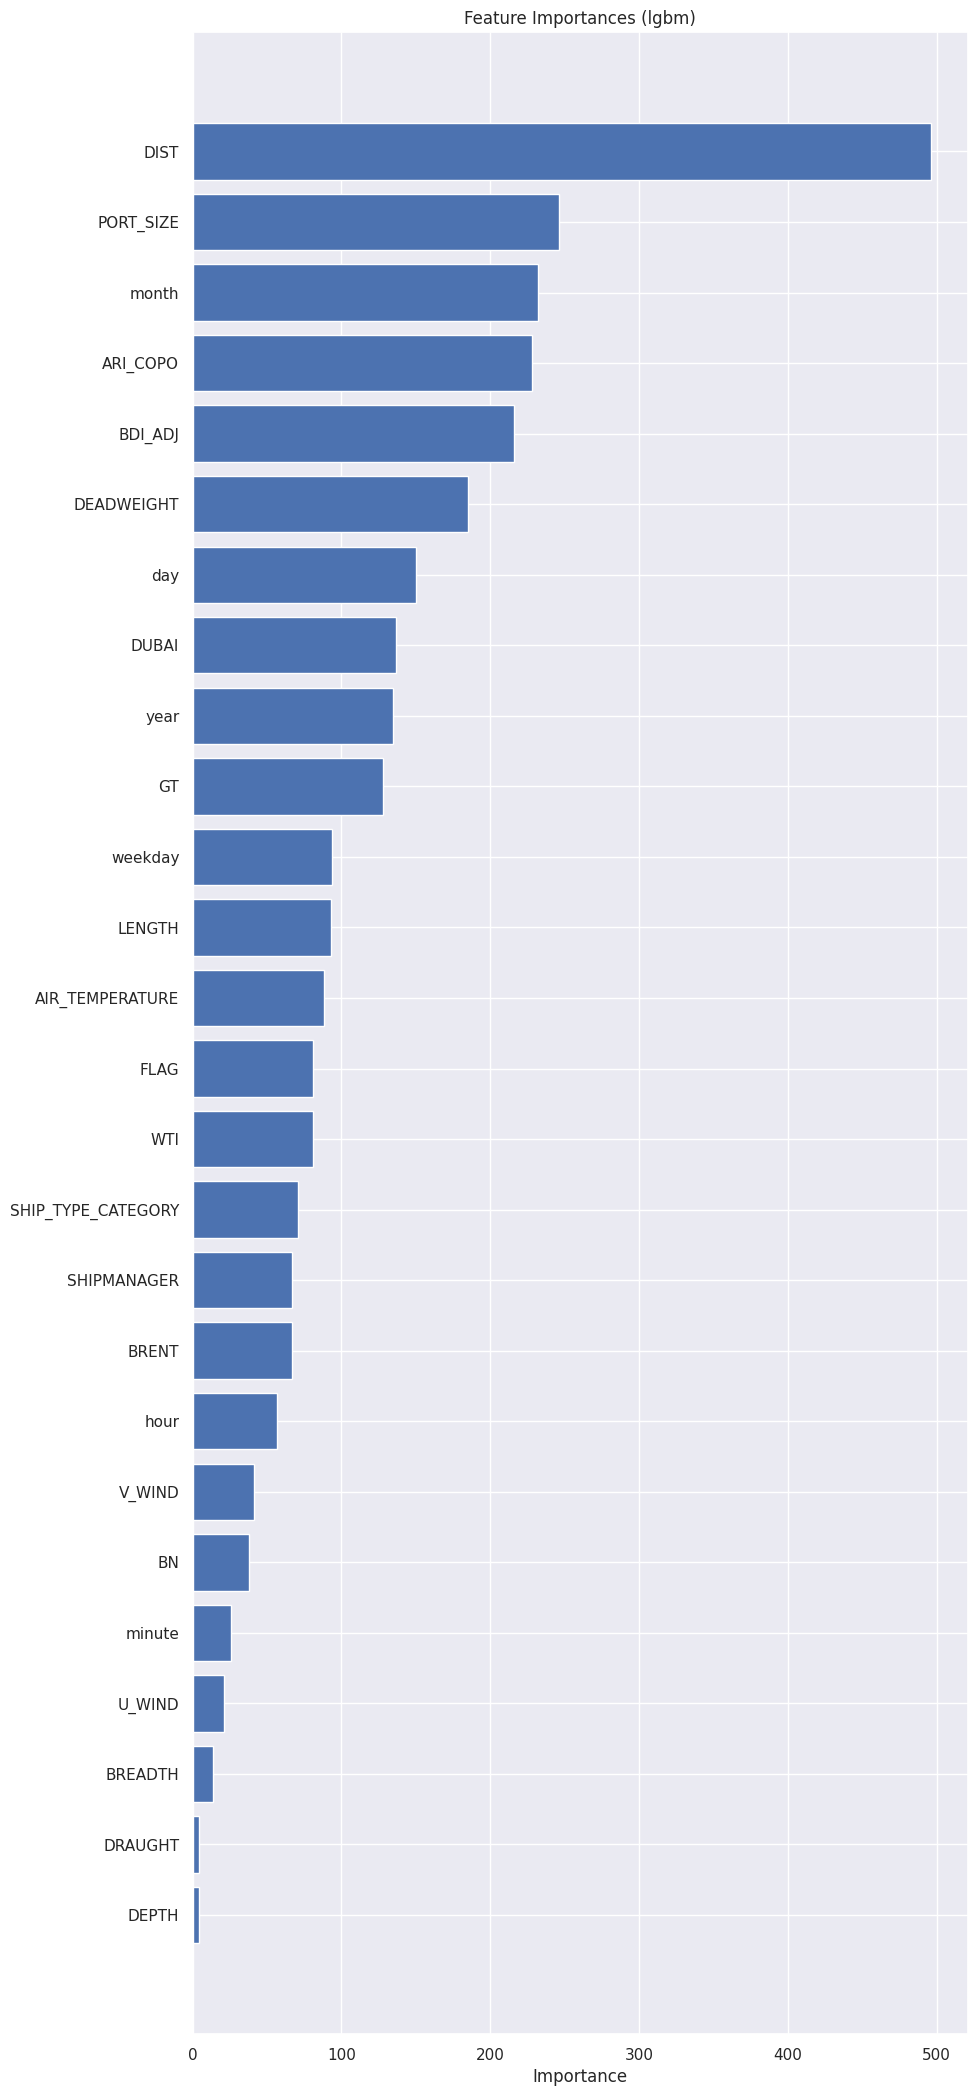

In [75]:
def train_and_evaluate(model, model_name, train_x, train_y):
    print(f'Model Tune for {model_name}.')
    model.fit(train_x, train_y)

    feature_importances = model.feature_importances_
    sorted_idx = feature_importances.argsort()

    plt.figure(figsize=(10, len(train_x.columns)))
    plt.title(f"Feature Importances ({model_name})")
    plt.barh(range(train_x.shape[1]), feature_importances[sorted_idx], align='center')
    plt.yticks(range(train_x.shape[1]), train_x.columns[sorted_idx])
    plt.xlabel('Importance')
    plt.show()

    return model, feature_importances

train_x = train.drop(columns=['CI_HOUR'])
train_y = train['CI_HOUR']

# Model Tune for LGBM
lgbm_model, lgbm_feature_importances = train_and_evaluate(LGBMRegressor(), 'lgbm', train_x, train_y)

In [76]:
lgbm_feature_importances

array([ 71, 496,  14, 185,   4,   4, 128,  93,  67,  81,  21,  41,  88,
        38, 137,  67,  81, 216, 246, 135, 232, 150,  57,  26,  94, 228],
      dtype=int32)

In [77]:
train_x = train.drop(columns=['CI_HOUR'])
train_y = train['CI_HOUR']

threshold = 71 # Your Threshold
low_importance_features = train_x.columns[lgbm_feature_importances < threshold]

train_x = train_x.drop(columns=low_importance_features)
test = test.drop(columns=low_importance_features)

In [78]:
low_importance_features

Index(['BREADTH', 'DEPTH', 'DRAUGHT', 'SHIPMANAGER', 'U_WIND', 'V_WIND', 'BN',
       'BRENT', 'hour', 'minute'],
      dtype='object')

In [79]:
train_x

,SHIP_TYPE_CATEGORY,DIST,DEADWEIGHT,GT,LENGTH,FLAG,AIR_TEMPERATURE,DUBAI,WTI,BDI_ADJ,PORT_SIZE,year,month,day,weekday,ARI_COPO
0,0,0.153698,0.180738,0.162339,0.526316,18,0.602757,0.249169,0.487138,0.248581,0.634161,2020,10,15,3,22
1,2,0.316133,0.093588,0.118007,0.526316,100,0.710526,0.472363,0.601066,0.399694,0.616515,2019,9,17,1,23
2,2,0.452181,0.284476,0.406375,0.736842,65,0.521303,0.452860,0.586190,0.070168,0.665804,2019,2,23,5,29
3,1,0.000000,0.003441,0.002322,0.131579,79,0.680451,0.258002,0.488068,0.195839,0.024781,2020,9,18,4,63
4,2,0.044073,0.068086,0.080853,0.421053,87,0.689223,0.672818,0.779396,0.182109,0.073567,2022,8,13,5,85
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
367436,0,0.295119,0.230503,0.215959,0.552632,65,0.639942,0.417439,0.578504,0.232156,0.136323,2017,11,11,5,39
367437,3,0.000000,0.002922,0.001478,0.105263,57,0.617794,0.803306,0.882167,0.369988,0.209594,2022,4,29,4,61
367438,2,0.008844,0.061649,0.105341,0.421053,25,0.800752,0.736488,0.826939,0.291521,1.000000,2022,7,14,3,90
367439,1,0.000000,0.005694,0.002533,0.157895,57,0.538847,0.316862,0.524701,0.200607,0.024781,2020,12,22,1,63


LGBM 모델 특성 중요도로 특성 삭제

In [ ]:
# # 전처리된 train 및 test 데이터를 CSV 파일로 저장
# train_x.to_csv("/content/drive/MyDrive/프로젝트/HD현대 AI Challenge /data/train_x.csv", index=False)
# test.to_csv("/content/drive/MyDrive/프로젝트/HD현대 AI Challenge /data/test_x.csv", index=False)
# train_y.to_csv("/content/drive/MyDrive/프로젝트/HD현대 AI Challenge /data/train_y.csv", index=False)

##3. 모델 학습 및 검증

In [ ]:
# train_x = pd.read_csv('/content/drive/MyDrive/프로젝트/HD현대 AI Challenge /data/train_x.csv')
# test = pd.read_csv('/content/drive/MyDrive/프로젝트/HD현대 AI Challenge /data/test_x.csv')
# train_y = pd.read_csv('/content/drive/MyDrive/프로젝트/HD현대 AI Challenge /data/train_y.csv')

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

# 훈련 세트와 검증 세트로 분할
X_train, X_val, y_train, y_val = train_test_split(train_x, train_y, test_size=0.2, random_state=42)

# 모델 리스트
models = [
    ("GradientBoosting", GradientBoostingRegressor(random_state=42)),
    ("XGBoost", XGBRegressor(random_state=42)),
    ("LightGBM", LGBMRegressor(random_state=42)),
    ("CatBoost", CatBoostRegressor(random_state=42, verbose=0)),
    ("RandomForest", RandomForestRegressor(random_state=42)),
    ("ExtraTrees", ExtraTreesRegressor(random_state=42)),
]

# 각 모델을 학습하고 MAE 출력
for model_name, model in models:
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    mae = mean_absolute_error(y_val, y_pred)
    print(f"{model_name} MAE: {mae}")

GradientBoosting MAE: 59.618633529983875
XGBoost MAE: 44.61204376391935
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.079696 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2197
[LightGBM] [Info] Number of data points in the train set: 293952, number of used features: 16
[LightGBM] [Info] Start training from score 62.041608
LightGBM MAE: 51.84815434595105
CatBoost MAE: 42.28061189476986
RandomForest MAE: 52.308776526658406
ExtraTrees MAE: 51.74782249975738


In [84]:
from sklearn.ensemble import  ExtraTreesRegressor

# 모델 리스트와 그에 대한 파라미터 그리드 정의
models = {
    # 'GradientBoostingRegressor': (GradientBoostingRegressor(), {
    #     'n_estimators': [100, 300, 500],
    #     'learning_rate': [0.01, 0.1, 0.2],
    #     'max_depth': [3, 5, 7]
    # }),
    'XGBoost': (XGBRegressor(), {
        'n_estimators': [1400, 1500, 1600],
        'learning_rate': [0.25,0.3,0.35],
        'max_depth': [6,7,8]
    }),
    # 'LightGBM': (LGBMRegressor(), {
    #     'n_estimators': [100, 300, 500],
    #     'learning_rate': [0.01, 0.1, 0.2],
    #     'max_depth': [3, 5, 7]
    # }),
    # 'CatBoost': (CatBoostRegressor(verbose=0), {
    #     'iterations': [100, 200, 300],
    #     'learning_rate': [0.01, 0.1, 0.2],
    #     'depth': [4, 6, 8]
    # }),
    # 'RandomForestRegressor': (RandomForestRegressor(), {
    #     'n_estimators': [100, 300, 500],
    #     'max_depth': [10, 20, 30],
    #     'min_samples_split': [2, 5, 10]
    # }),
    # 'ExtraTreesRegressor': (ExtraTreesRegressor(), {
    #     'n_estimators': [100, 300, 500],
    #     'max_depth': [10, 20, 30],
    #     'min_samples_split': [2, 5, 10]
    # })
}

# 각 모델에 대한 GridSearchCV 수행
best_models = {}
for model_name, (model, param_grid) in models.items():
    grid_search = GridSearchCV(model, param_grid, cv=5, scoring='neg_mean_absolute_error', n_jobs=-1)
    grid_search.fit(X_train, y_train)
    best_models[model_name] = grid_search.best_estimator_

    # 최적의 하이퍼파라미터 출력
    print(f"Best Hyperparameters for {model_name}:")
    print(grid_search.best_params_)

    # 최적의 모델로 예측 및 성능 측정
    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_val)
    mae = mean_absolute_error(y_val, y_pred)
    print(f"Best {model_name} MAE: {mae}")

# 최적의 모델을 저장하거나 활용할 수 있다.
# best_models 딕셔너리에 저장된 최적의 모델들을 활용하여 예측 및 분석을 수행할 수 있다.

KeyboardInterrupt: ignored

In [80]:
!nvidia-smi

Mon Oct 16 04:45:08 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   65C    P0    31W /  70W |    877MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [81]:
import tensorflow as tf
device_name=tf.test.gpu_device_name()
if device_name!='/device:GPU:0':
    raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [82]:
import tensorflow as tf

# GPU 상태 확인
tf.config.experimental.get_memory_info('GPU:0')


{'current': 0, 'peak': 0}

In [83]:
# XGBoost 모델 최적화

# 훈련 세트와 검증 세트로 분할
X_train, X_val, y_train, y_val = train_test_split(train_x, train_y, test_size=0.2, random_state=42)

xgb_model = XGBRegressor(random_state=42,learning_rate=0.3,max_depth=7,n_estimators=1500)
xgb_model.fit(X_train, y_train)
xgb_pred = xgb_model.predict(X_val)
xgb_mae = mean_absolute_error(y_val, xgb_pred)
print(f"XGBRegressor MAE: {xgb_mae}")

XGBRegressor MAE: 22.427667310797563


In [ ]:
# Gradient Boosting 모델 최적화

# 훈련 세트와 검증 세트로 분할
X_train, X_val, y_train, y_val = train_test_split(train_x, train_y, test_size=0.2, random_state=42)
gb_model=GradientBoostingRegressor(random_state=42,learning_rate=0.1,max_depth=5,n_estimators=1000)
gb_model.fit(X_train, y_train)
gb_pred = gb_model.predict(X_val)
gb_mae = mean_absolute_error(y_val, gb_pred)
print(f"Gradient Boosting Regressor MAE: {gb_mae}")

In [ ]:
# Validation function
n_folds = 5

def mae_cv(model):
    kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(train_x.values)
    mae = -cross_val_score(model, train_x.values, train_y, scoring="neg_mean_absolute_error", cv=kf)
    return mae

In [ ]:
xgb_model = XGBRegressor(random_state=42,learning_rate=0.3,max_depth=7,n_estimators=1500)

score = mae_cv(xgb_model)
xgb_score = score.mean()
print("XGBRegressor score: {:.4f} ({:.4f})".format(score.mean(), score.std()))

XGBRegressor score: 23.2130 (0.2378)


In [ ]:
import lightgbm as lgb

lgbm = lgb.LGBMRegressor()

# 5-Fold 설정
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# 각 fold의 모델로부터의 예측을 저장할 리스트와 MAE 점수 리스트
ensemble_predictions = []
scores = []

for train_idx, val_idx in tqdm(kf.split(train_x), total=5, desc="Processing folds"):
    X_t, X_val = train_x.iloc[train_idx], train_x.iloc[val_idx]
    y_t, y_val = train_y[train_idx], train_y[val_idx]

    # 두 모델 모두 학습
    lgbm.fit(X_t, y_t)

    # 각 모델로부터 Validation set에 대한 예측을 평균내어 앙상블 예측 생성
    val_pred = lgbm.predict(X_val)

    # Validation set에 대한 대회 평가 산식 계산 후 저장
    scores.append(mean_absolute_error(y_val, val_pred))

    # test 데이터셋에 대한 예측 수행 후 저장
    lgbm_pred = lgbm.predict(test)
    lgbm_pred = np.where(lgbm_pred < 0, 0, lgbm_pred)

    ensemble_predictions.append(lgbm_pred)

# K-fold 모든 예측의 평균을 계산하여 fold별 모델들의 앙상블 예측 생성
final_predictions = np.mean(ensemble_predictions, axis=0)

# 각 fold에서의 Validation Metric Score와 전체 평균 Validation Metric Score출력
print("Validation : MAE scores for each fold:", scores)
print("Validation : MAE:", np.mean(scores))

Processing folds:   0%|          | 0/5 [00:00<?, ?it/s]


KeyError: ignored

In [ ]:
xgb_model = XGBRegressor(random_state=42,learning_rate=0.3,max_depth=7,n_estimators=1500)

# 5-Fold 설정
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# 각 fold의 모델로부터의 예측을 저장할 리스트와 MAE 점수 리스트
ensemble_predictions = []
scores = []

for train_idx, val_idx in tqdm(kf.split(train_x), total=5, desc="Processing folds"):
    X_t, X_val = train_x.iloc[train_idx], train_x.iloc[val_idx]
    y_t, y_val = train_y[train_idx], train_y[val_idx]

    # 두 모델 모두 학습
    xgb_model.fit(X_t, y_t)

    # 각 모델로부터 Validation set에 대한 예측을 평균내어 앙상블 예측 생성
    val_pred = xgb_model.predict(X_val)

    # Validation set에 대한 대회 평가 산식 계산 후 저장
    scores.append(mean_absolute_error(y_val, val_pred))

    # test 데이터셋에 대한 예측 수행 후 저장
    xgb_pred = xgb_model.predict(test)
    xgb_pred = np.where(xgb_pred < 0, 0, xgb_pred)

    ensemble_predictions.append(xgb_pred)

# K-fold 모든 예측의 평균을 계산하여 fold별 모델들의 앙상블 예측 생성
final_predictions = np.mean(ensemble_predictions, axis=0)

# 각 fold에서의 Validation Metric Score와 전체 평균 Validation Metric Score출력
print("Validation : MAE scores for each fold:", scores)
print("Validation : MAE:", np.mean(scores))

Processing folds: 100%|██████████| 5/5 [06:20<00:00, 76.13s/it]

Validation : MAE scores for each fold: [22.48127482586134, 23.214573765112522, 23.36989128282221, 23.23184157830776, 23.25585406735194]
Validation : MAE: 23.110687103891156


##4. 결과 제출

In [ ]:
# 제출용 sample 파일불러오기
submission = pd.read_csv('/content/drive/MyDrive/프로젝트/HD현대 AI Challenge /data/sample_submission.csv')
submission.shape

(244989, 2)

In [ ]:
submission["CI_HOUR"]=final_predictions
submission.head()

,SAMPLE_ID,CI_HOUR
0,TEST_000000,81.784546
1,TEST_000001,451.872009
2,TEST_000002,0.127270
3,TEST_000003,28.451904
4,TEST_000004,21.127741


In [ ]:
submission.to_csv("/content/drive/MyDrive/프로젝트/HD현대 AI Challenge /data/submission7.csv",index = False)